In [1]:
from typing import TypedDict, Annotated, List, Literal, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
import random
from langchain_core.prompts import ChatPromptTemplate
from datetime import datetime
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
import os

from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

from langchain.chat_models import init_chat_model

llm=init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000019EDDD5C910>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000019EDDEA0810>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [2]:
# ===================================
# State Definition
# ===================================            

class CEOState(MessagesState):
    # single dispatcher field
    next_agent: str = ""        
    # embed both team-leaders
    technical_draft: str = ""              
    summary_draft: str = "" 

    research_data: str = ""      
    market_insights: str = ""  
    # final outputs
    task_complete: bool = False
    current_task: str = ""

In [3]:
# ===================================
# Supervisor (CEO) with Groq LLM
# ===================================

def create_ceo_chain():
    """Creates the CEO decision chain based on CEOState."""
    
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are the CEO supervising a multi‑agent workflow:

1. ResearchTeamLeader – gathers `research_data` and `market_insights`.
2. WritingTeamLeader  – gathers `technical_draft` and `summary_draft`.

Based on the current state and conversation, decide which agent should work next.
If the task is complete, respond with 'DONE'.

Current state:
- Has market_insights: {has_market_insights}
- Has summary_draft: {has_summary_draft}

Respond with ONLY the agent name (ResearchTeamLeader/WritingTeamLeader) or 'DONE'.
"""),
        ("human", "{task}")
    ])
    
    return supervisor_prompt | llm


In [4]:
# ===================================
# ResearchTeamLeader with Groq LLM
# ===================================

def create_researchleader_chain():
    """Creates the ResearchTeamLeader decision chain based on ResearchTeamLeaderState."""
    
    researchleader_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are the ResearchTeamLeader coordinating two sub‑agents:
1. DataResearcher   – gathers `research_data`
2. MarketResearcher – gathers `market_insights`

Based on the current state and conversation, decide which agent should work next.
If the task is complete, respond with 'DONE'.

Current state:
- Has research_data: {has_research_data}
- Has market_insights: {has_market_insights}

Respond with ONLY the agent name (DataResearcher/MarketResearcher) or 'DONE'.

"""),
        ("human", "{task}")
    ])
    
    return researchleader_prompt | llm

In [5]:
# ===================================
# WritingTeamLeader with Groq LLM
# ===================================

def create_writingleader_chain():
    """Creates the WritingTeamLeader decision chain based on WritingTeamLeaderState."""
    
    writingleader_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are the WritingTeamLeader managing two sub‑agents:
1. TechnicalWriter – produces `technical_draft`
2. SummaryWriter   – produces `summary_draft`

Based on the current state and conversation, decide which agent should work next.
If the task is complete, respond with 'DONE'..

Current state:
- Has technical_draft: {has_technical_draft}
- Has summary_draft: {has_summary_draft}

Respond with ONLY the agent name (TechnicalWriter/SummaryWriter) or 'DONE'.
   """),
        ("human", "{task}")
    ])
    
    return writingleader_prompt | llm

In [6]:
# ===================================
# CEO / Supervisor Agent
# ===================================
def ceo_agent(state: CEOState) -> Dict:
    """CEO decides next agent using Groq LLM."""
    # 1) get latest human task
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"

    # 2) check which phases are done
    has_market_insights = bool(state.get("market_insights",""))
    has_summary_draft   = bool(state.get("summary_draft",""))

    # 3) ask the CEO chain
    chain    = create_ceo_chain()
    decision = chain.invoke({
        "task": task,
        "has_market_insights":has_market_insights,
        "has_summary_draft":has_summary_draft
    })
        
    # Parse decision
    decision_text = decision.content.strip().lower()
    print(decision_text)
    

    # 4) map to code
    if "done" in decision_text or has_summary_draft:
        next_agent    = "end"
        ceo_msg = "✅ CEO: All tasks complete! Well done."
    elif "ResearchTeamLeader" in decision_text or not has_market_insights:
        next_agent    = "ResearchTeamLeader"
        ceo_msg = "📋 CEO: Handing off to the Research Team Leader..."
    elif "WritingTeamLeader" in decision_text or (has_market_insights and not has_summary_draft):
        next_agent    = "WritingTeamLeader"
        ceo_msg = "📋 CEO: Handing off to the Writing Team Leader..."
    else:
        next_agent    = "end"
        ceo_msg = "✅ CEO: Task appears complete."

    return {
        "messages":     [AIMessage(content=ceo_msg)],
        "next_agent":   next_agent,
        "current_task": task
    }


# ===================================
# ResearchTeamLeader Agent
# ===================================
def researchleader_agent(state: CEOState) -> Dict:
    """ResearchTeamLeader decides next sub‑agent using Groq LLM."""
    # latest human instruction
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"
    # what’s done?
    has_research_data = bool(state.get("research_data",""))
    has_market_insights = bool(state.get("market_insights",""))

    # call chain
    chain    = create_researchleader_chain()
    decision = chain.invoke({
        "task": task,
        "has_research_data":  has_research_data,
        "has_market_insights":  has_market_insights

    })

    # Parse decision
    decision_text = decision.content.strip().lower()
    print(decision_text)

    # route
    if "done" in decision_text or has_market_insights:
        next_agent  = "ceo"  # back to CEO
        research_leader_msg = "✅ ResearchTeamLeader: Research complete."
    elif "DataResearcher" in decision_text or not has_research_data:
        next_agent      = "DataResearcher"
        research_leader_msg  = "📊 ResearchTeamLeader: Assigning DataResearcher."
    elif "MarketResearcher" in decision_text or (has_research_data and not has_market_insights):
        next_agent  = "MarketResearcher"
        research_leader_msg  = "📈 ResearchTeamLeader: Assigning MarketResearcher."
    else:
        next_agent  = "ceo"
        research_leader_msg  = "✅ ResearchTeamLeader: Moving back to CEO."

    return {
        "messages":     [AIMessage(content=research_leader_msg)],
        "next_agent":   next_agent,
        "current_task": task
    }


# ===================================
# WritingTeamLeader Agent
# ===================================
def writingleader_agent(state: CEOState) -> Dict:
    """WritingTeamLeader decides next sub‑agent using Groq LLM."""
    # latest human instruction
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"

    # what’s done?
    has_technical_draft = bool(state.get("technical_draft",""))
    has_summary_draft = bool(state.get("summary_draft",""))
    # call chain
    chain    = create_writingleader_chain()
    decision = chain.invoke({
        "task": task,
        "has_technical_draft":   has_technical_draft,
        "has_summary_draft":     has_summary_draft
    })
    
    # Parse decision
    decision_text = decision.content.strip().lower()
    print(decision_text)

    # route
    if "done" in decision_text or has_summary_draft:
        next_agent      = "ceo"  # back to CEO
        writing_leader_msg = "✅ WritingTeamLeader: Drafting complete."
    elif "TechnicalWriter" in decision_text or not has_technical_draft:
        next_agent  = "TechnicalWriter"
        writing_leader_msg  = "✍️ WritingTeamLeader: Assigning TechnicalWriter."
    elif "SummaryWriter" in decision_text or (has_technical_draft and not has_summary_draft):
        next_agent  = "SummaryWriter"
        writing_leader_msg  = "📝 WritingTeamLeader: Assigning SummaryWriter."
    else:
        next_agent  = "ceo"
        writing_leader_msg  = "✅ WritingTeamLeader: Moving back to CEO."

    return {
        "messages":     [AIMessage(content=writing_leader_msg)],
        "next_agent":   next_agent,
        "current_task": task
    }

In [7]:
# ===================================
# Agent: DataResearcher (using Groq)
# ===================================


def data_researcher_agent(state: CEOState) -> Dict:
    """DataResearcher uses Groq to gather raw research_data"""
    task    = state.get("current_task", "research topic")
    # Build prompt
    prompt = f"""As a Data Research specialist, collect the raw factual data on:
    
    Task: {task}

    Provide:
    1. Key facts and background
    2. Important statistics or numbers
    3. Relevant case studies or examples

    Be concise but thorough."""
    # Invoke LLM
    resp = llm.invoke([HumanMessage(content=prompt)])
    research_data = resp.content
    # Agent message
    msg = (
        f"🔬 DataResearcher: Completed raw data gathering for '{task}'.\n"
        f"Sample:\n{research_data[:400]}..."
    )
    return {
        "messages":      [AIMessage(content=msg)],
        "research_data": research_data,
        "next_agent":    "ResearchTeamLeader"
    }


# ===================================
# Agent: MarketResearcher (using Groq)
# ===================================
def market_researcher_agent(state: CEOState) -> Dict:
    """MarketResearcher uses Groq to gather market_insights"""
    research_data = state.get("research_data", "")
    task  = state.get("current_task", "")
    # Build prompt
    prompt = f"""As a Market Research specialist, gather market insights for:

    Research Data:
    {research_data}

    Include:
    1. Current market trends
    2. Competitive landscape
    3. Customer behavior or preferences
    4. Growth projections

    Keep it actionable and data‑driven."""
    # Invoke LLM
    resp = llm.invoke([HumanMessage(content=prompt)])
    market_insights = resp.content
    # Agent message
    msg = (
        f"📈 MarketResearcher: Completed market insights gathering for '{task}'.\n"
        f"Sample:\n{market_insights[:400]}..."
    )
    return {
        "messages":        [AIMessage(content=msg)],
        "market_insights": market_insights,
        "next_agent":      "ResearchTeamLeader"
    }


# ===================================
# Agent: TechnicalWriter (using Groq)
# ===================================
def technical_writer_agent(state: CEOState) -> Dict:
    """TechnicalWriter uses Groq to write the main technical_draft"""
    
    research_data = state.get("research_data", "")
    market_insights = state.get("market_insights", "")
    task = state.get("current_task", "")
    # Build prompt
    prompt = f"""As a Technical Writer, draft the main section of the report on:

    Task: {task}

    Research Data:
    {research_data}

    Market Insights:
    {market_insights}

    Write a detailed technical section covering:
    1. Methodology or process
    2. Data interpretation
    3. Technical details and explanations

    Maintain a clear, professional tone."""
    # Invoke LLM
    resp = llm.invoke([HumanMessage(content=prompt)])
    technical_draft = resp.content
    # Agent message
    msg = (
        f"✍️ TechnicalWriter: Completed technical draft for '{task}'.\n"
        f"Sample:\n{technical_draft[:400]}..."
    )
    return {
        "messages":        [AIMessage(content=msg)],
        "technical_draft": technical_draft,
        "next_agent":      "WritingTeamLeader"
    }


# ===================================
# Agent: SummaryWriter (using Groq)
# ===================================
def summary_writer_agent(state: CEOState) -> Dict:
    """SummaryWriter uses Groq to write the summary_draft"""
    research_data = state.get("research_data", "")
    market_insights = state.get("market_insights", "")
    technical_draft= state.get("technical_draft", "")
    task = state.get("current_task", "")
    # Build prompt
    prompt = f"""As a Summary Writer, produce a concise summary for:

    Task: {task}

    Research Data:
    {research_data}

    Market Insights:
    {market_insights}

    Technical Draft:
    {technical_draft}

    Your summary should include:
    1. Executive Summary
    2. Key Findings  
    3. Analysis & Insights
    4. Recommendations
    5. Conclusion

    Keep it professional and concise."""
    # Invoke LLM
    resp = llm.invoke([HumanMessage(content=prompt)])
    summary_draft = resp.content
    # Agent message
    msg = f"""
    📄 FINAL REPORT
    {'='*50}
    Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
    Topic: {task}
    {'='*50}

    {summary_draft}

    {'='*50}
    Report compiled by Multi-Agent AI System powered by Groq
    """
    return {
        "messages":      [AIMessage(content="✍️ Summary Writer: Report complete! See below for the full document.")],
        "summary_draft": msg,
        "next_agent":    "WritingTeamLeader"

    }


In [8]:
def unified_router(state: CEOState) -> Literal["ceo", "research_team_leader", "data_researcher", "market_researcher", "writing_team_leader", "technical_writer", "summary_writer", "__end__"]:
    """Unified router that can route to any agent in the system"""
    
    next_agent = state.get("next_agent", "ceo")
    
    if next_agent == "end" or state.get("task_complete", False):
        return END
        
    # Map the agent names to match the graph node names
    agent_mapping = {
        "ceo": "ceo",
        "ResearchTeamLeader": "research_team_leader", 
        "research_team_leader": "research_team_leader",
        "DataResearcher": "data_researcher",
        "data_researcher": "data_researcher",
        "MarketResearcher": "market_researcher",
        "market_researcher": "market_researcher", 
        "WritingTeamLeader": "writing_team_leader",
        "writing_team_leader": "writing_team_leader",
        "TechnicalWriter": "technical_writer",
        "technical_writer": "technical_writer",
        "SummaryWriter": "summary_writer",
        "summary_writer": "summary_writer"
    }
    
    if next_agent in agent_mapping:
        return agent_mapping[next_agent]
        
    return "ceo"

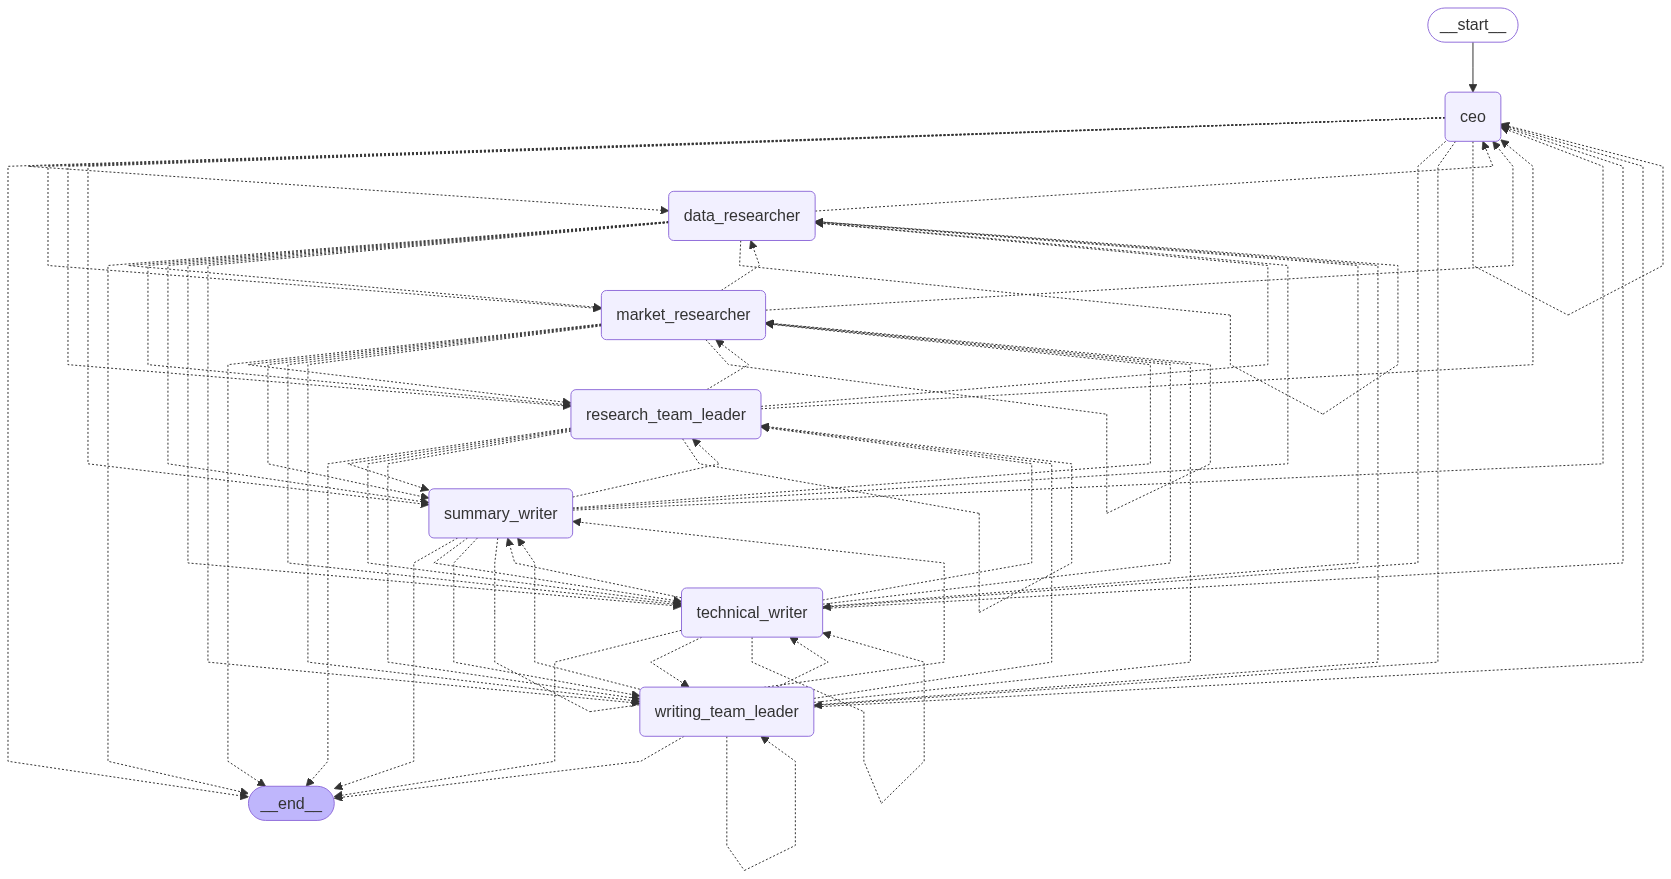

In [9]:
# Create the main CEO workflow
ceo_workflow = StateGraph(CEOState)

# Add all nodes to the main graph
ceo_workflow.add_node("ceo", ceo_agent)
ceo_workflow.add_node("research_team_leader", researchleader_agent)
ceo_workflow.add_node("data_researcher", data_researcher_agent)
ceo_workflow.add_node("market_researcher", market_researcher_agent)
ceo_workflow.add_node("writing_team_leader", writingleader_agent)
ceo_workflow.add_node("technical_writer", technical_writer_agent)
ceo_workflow.add_node("summary_writer", summary_writer_agent)

# Set entry point
ceo_workflow.set_entry_point("ceo")

# Add routing for all nodes - each node can route to any other node
all_nodes = ["ceo", "research_team_leader", "data_researcher", "market_researcher", 
             "writing_team_leader", "technical_writer", "summary_writer"]

for node in all_nodes:
    ceo_workflow.add_conditional_edges(
        node,
        unified_router,
        {
            "ceo": "ceo",
            "research_team_leader": "research_team_leader",
            "data_researcher": "data_researcher", 
            "market_researcher": "market_researcher",
            "writing_team_leader": "writing_team_leader",
            "technical_writer": "technical_writer",
            "summary_writer": "summary_writer",
            END: END
        }
    )

# Compile the main graph
ceo_graph = ceo_workflow.compile()

# Display the graph
ceo_graph

In [ ]:
response=ceo_graph.invoke(HumanMessage(content="What are the benefits and risks of AI in healthcare?"))

researchteamleader
dataresearcher
marketresearcher
dataresearcher
researchteamleader
technicalwriter
technicalwriter
summarywriter
writingteamleader


In [12]:
#download the final report in txt

response['summary_draft']

"\n    📄 FINAL REPORT\n    ==================================================\n    Generated: 2025-07-17 19:46\n    Topic: ✍️ TechnicalWriter: Completed technical draft for '📋 CEO: Handing off to the Writing Team Leader...'.\nSample:\n**Technical Section: Methodology, Data Interpretation, and Technical Details**\n\n**1. Methodology or Process**\n\nThe methodology for handing off to the Research Team Leader involves a structured approach that ensures a smooth transition of responsibilities and tasks from the CEO to the designated research team leader. The process includes the following steps:\n\n1. **Task Identification**: Identify th...\n    ==================================================\n\n    **Technical Draft Summary Report: Handing Off to the Research Team Leader**\n\n**Executive Summary:**\n\nThis technical draft report explores the benefits of handing off research tasks to the Research Team Leader, a process that involves a structured approach to ensure a smooth transition of

In [13]:
with open("summary_draft.txt", "w", encoding="utf-8") as f:
    f.write(response["summary_draft"])
print("Written to summary_draft.txt")

Written to summary_draft.txt
